# To do list

1 - Calcul de la grid include protein

2 - More pixels (Decaying radii) 20x20x20 --> 254x254x254x15 (memory)!!!! (Mode)

3 - Elements, atom types...

4 - Model explainability (transpose convolutional)

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import collections
from keras.models import model_from_yaml
import sparse
import sys
import os
import ipymol
from collections import Counter
from mpl_toolkits import mplot3d
from matplotlib import cm
from sklearn.cluster import KMeans
import plotly.express as px

Using TensorFlow backend.


In [4]:
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolToPDBFile

RDKit WARNING: [12:22:45] Enabling RDKit 2019.09.2 jupyter extensions


In [5]:
import istarmap
import h5py
import pandas
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import glob
import istarmap
from keras.models import model_from_yaml
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
from sklearn.model_selection import train_test_split
import h5py
import os
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import subprocess
import glob

from scipy import sparse as scipy_sparse
from rdkit.Chem import Descriptors
from itertools import count

# Functions and classes

In [6]:
def retrieve_vocabulary_from_sdf(sdfs):
    vocabulary_elements=[]; features=[]
    for sdf in tqdm(sdfs):
        supl = Chem.SDMolSupplier(sdf, removeHs=False)
        mols = [mol for mol in supl]
        getatoms = [mol.GetAtoms() for mol in mols]
        elements = set([getatoms[i][x].GetSymbol() for i in range(len(getatoms)) for x in range(len(getatoms[i]))])
        for element in elements:
            if element not in vocabulary_elements:
                vocabulary_elements.append(element)
    vocabulary_elements = {res:i for i, res in enumerate(vocabulary_elements)}
    features = len(vocabulary_elements)
    return  vocabulary_elements, features

In [7]:
class Grid(object):

    def __init__(self, center, side, resolution=None):
        self.center = center
        self.side = side
        self.resolution = resolution
        self.vertexes = self._calculate_vertexes()
    def _calculate_vertexes(self):
        center = self.center
        side = self.side

        vertexes = []
        v1 = center + [-side/2, -side/2, -side/2]
        v2 = center + [side/2, -side/2, -side/2]
        v3 = center + [-side/2, -side/2, side/2]
        v4 = center + [-side/2, side/2, -side/2]
        v5 = center + [side/2, side/2, -side/2]
        v6 = center + [side/2, -side/2, side/2]
        v7 = center + [-side/2, side/2, side/2]
        v8 = center + [side/2, side/2, side/2]
        vertexes.extend([v1, v2, v3, v4, v5, v6, v7, v8])
        return vertexes

    def calculate_pixels(self):
        print("Calculating pixels...")
        rear_back_pixel_center = self.rear_back_pixel_center = self.vertexes[0]  + np.array((self.resolution/2, self.resolution/2, self.resolution/2))
        self.n_pixels = n_pixels =  int(self.side / self.resolution)

    def is_point_inside(self, point):
        dist = np.linalg.norm(self.center-point)
        dist_center_diagonal = np.linalg.norm(self.center-self.vertexes[0])
        if dist < dist_center_diagonal:
            return True
        else:
            return False

    def plot(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        for vertex in self.vertexes:
            vx, vy,vz = vertex.tolist()
            ax.scatter(vx, vy, vz)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        return fig.show()


In [8]:
def visualize(result, y_train, nsample, npixels=40):
    npixel = npixels
    heat_map_grids = []
    heat_elements_grids = []
    for plane in range(npixels):
        sample = result[nsample].todense()[:,:,plane].copy()
        explanation_grid = np.zeros((npixel, npixel)).copy()
        explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += 1
                        explanation_str_grid[i, j] += element
        heat_map_grids.append(explanation_grid)
        heat_elements_grids.append(explanation_str_grid)
    
    final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
    final_grid = np.zeros((npixel, npixel)).copy()
    for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
        final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
        final_grid += grid
    
    print(final_grid_elements)
    
    print("Class", np.argmax(y_train[nsample]), "Prob", y_train[nsample])
    data = final_grid
    plt.matshow(data)
    plt.show()
    

In [9]:
def extract_cnn_input(sdf_lig, sdf_rec, center_of_mass, vocabulary_elements, features, resolution, volume=True,
                     include_rec=False, just_receptor=True, just_ligands=False):

    cm = center_of_mass # finally the mean cm
    side = 20
    print("CM", cm)
    print("Build grid")
    grid2 = Grid(cm, side, resolution)
    grid2.calculate_pixels()
    
    tot_atoms = []
    tot_mols = []
    
    if include_rec:
        sdfs = [sdf_lig, sdf_rec]
    if just_receptor:
        sdfs = [sdf_rec]
    if just_ligands:
        sdfs = [sdf_lig]

    for sdf in sdfs:
        print("Load trajectory from {}".format(os.path.basename(sdf)))
        supl = Chem.SDMolSupplier(sdf, removeHs=False)
        mols = [mol for mol in supl]
        getatoms = [mol.GetAtoms() for mol in mols]
        atoms = [[getatoms[i][x].GetSymbol() for x in range(len(getatoms[i]))] for i in range(len(getatoms))]
        conf = [mol.GetConformer() for mol in mols] # for each molecule in the sdf
        num_atoms = [co.GetNumAtoms() for co in conf]
        pos = np.array([[list(co.GetAtomPosition(num)) for num in range(num_atoms[i])] for i,co in enumerate(conf)])
        # now we only take atoms of ligand in a 20A radius (supposed to be all of them if small)
        us_atoms = [[atoms[j][i] for i in range(len(atoms[j])) if np.linalg.norm(pos[j][i]- cm) <= side ] for j in range(len(atoms))]
        tot_atoms += us_atoms
        tot_mols += mols
    print("Filling grid with atom info")
    atoms_all_mols, dict_at_pos, core_atoms, individuals = fill_grid_with_atoms(grid2, tot_mols, tot_atoms, cm, vocabulary_elements, features, side=side, 
                                                       volume=volume, include_rec=include_rec, just_receptor=just_receptor, 
                                                       just_ligands=just_ligands)
    return [atoms_all_mols, dict_at_pos, core_atoms, individuals, atoms, sdf_lig, sdf_rec]


In [10]:
def fill_grid_with_atoms(grid2, mols, atoms, cm, vocabulary_elements, features, side, include_rec=False, just_receptor=True, just_ligands=False, volume=True):

    at_all_mols = []
    dict_at_pos = {}
    core_atoms = {}
    individuals = {}
    print(len(mols), len(atoms))
    for mol in tqdm(range(len(mols))):
            sparse_matrix_dict = {}
            atoms_per_pixel = np.zeros((grid2.n_pixels, grid2.n_pixels, grid2.n_pixels, features),  dtype=int)
            molec = mols[mol]
            conf = molec.GetConformer() # for each molecule in the sdf
            num_atoms = conf.GetNumAtoms()
            coords_mol = np.array(list([conf.GetAtomPosition(num) for num in range(num_atoms)]))
            dict_at_pos[mol] = {}
            core_atoms[mol] = {}
            individuals[mol] = {}
            for atom in np.unique(atoms[mol]):
                dict_at_pos[mol][atom] = []
            for tt, atom in enumerate(range(len(atoms[mol]))):
                element = atoms[mol][atom]
                coords = coords_mol[atom]
                #assert grid2.is_point_inside(coords), coords
                ixs = np.array([int(round((x/grid2.resolution))) for x in np.array(np.array(coords) - np.array(grid2.rear_back_pixel_center))])
                #computing volumes
                if volume:
                    idxs = volume_occupancy(grid2.resolution, element, ixs, vocabulary_elements, side)
                else:
                    idxs = [ixs] 
                individuals[mol][tt] = idxs
                if len(dict_at_pos[mol][element]) == 0:
                    dict_at_pos[mol][element] = idxs
                    core_atoms[mol][element] = [ixs]
                else:
                    try:
                        dict_at_pos[mol][element] = np.concatenate((dict_at_pos[mol][element], idxs))
                        core_atoms[mol][element] =  np.concatenate((core_atoms[mol][element], [ixs]))
                    except ValueError:
                        print('ValueError', idxs)
                for idx in idxs:
                    try:
                        atoms_per_pixel[idx[0]][idx[1]][idx[2]]
                    except IndexError:
                        print('Cant assign atoms per pixel', idx)

                    pixel = atoms_per_pixel[idx[0]][idx[1]][idx[2]].copy()
                    try:
                        value =  pixel[vocabulary_elements[element]] + 1
                        pixel[vocabulary_elements[element]] = value
                    except TypeError:
                        value =  1
                        pixel[vocabulary_elements[element]] = value

                    atoms_per_pixel[idx[0], idx[1], idx[2]] = pixel
                    
                    index = (idx[0], idx[1], idx[2], vocabulary_elements[element])
                    sparse_matrix_dict[index]=value
            sparse_matrix_dict[(grid2.n_pixels-1,grid2.n_pixels-1,grid2.n_pixels-1,features-1)]=0
            try:
                x = sparse.COO(sparse_matrix_dict)
                at_all_mols.append(x)
            
            except ValueError:
                print('Probably negative indices detected')
                break
    print('moleculas', len(mols), len(core_atoms))
    return at_all_mols, dict_at_pos, core_atoms, individuals


In [11]:
def radius_assignation(folder, filename='radius.txt', costum=True):
    
    data = pandas.read_csv(os.path.join(folder, filename))[7:]
    radius = {}
    for i in data['Atomic']:
        if costum:
            if len(i.split()) == 7:
                radius[i.split()[1]] = float(i.split()[5])
            else:
                radius[i.split()[1]] = 1            
        else:
            radius[i.split()[1]] = 1
    return radius

In [12]:
def volume_occupancy(resolution, element, pixel, vocabulary_elements, side):
    
    minindx = 0 #minimum index
    maxindx = side/resolution #maximum index
    radii = radius_assignation(folder=folder)
    radius = radii[element]
    #sphere equation (x-a)**2 + (y-a)**2 + (z-a)**2 = r**2
    maxrange = int(max((radius-resolution)/resolution, 0))
    rangex = list(range(pixel[0]-maxrange, pixel[0] + maxrange+1))
    rangey = list(range(pixel[1]-maxrange, pixel[1] + maxrange+1))
    rangez = list(range(pixel[2]-maxrange, pixel[2] + maxrange+1))
    #computing activated pixels
    usefuls = []
    
    for i in range(len(rangex)):
        for j in range(len(rangey)):
            for k in range(len(rangez)):
                if (i*resolution)**2 + (j*resolution)**2 + (k*resolution)**2 <= radius**2:
                    usefuls += [[a,b,c] for a in [-i,i] for b in [-j,j] for c in [-k,k]]
                else:
                    break
    Vol_pixel = resolution**3
    Vol_element = 4/3*np.pi*radius**3
    usefuls = np.unique(usefuls, axis=0)
    movedp = [pixel + idx for idx in usefuls]
    moved = [ids for ids in movedp if not ids[ids<minindx].any() if not ids[ids>=maxindx].any()]
    if len(moved) == 0:
        print('Ep! atom outside box!')
    Aprox_vol = Vol_pixel*len(moved)
    Error_vol = (abs(Aprox_vol-Vol_element)/Vol_element)*100
   # print(element, '--->Real vol', Vol_element, 'Calculate vol', Aprox_vol, 'Error vol (%)', Error_vol)
    return moved

In [13]:
def labels_to_plot(Xt, folder, elem_core, nsample, vocabulary_elements):
    
    labels = []; pos = []; labels_core = []; pos_core = [] ; size = []
    x,y,z,l = Xt.shape
    for i in tqdm(range(x)):
        for j in range(y):
            for k in range(z):
                label = np.where(Xt[i][j][k] == 1)[0]
                if label.size > 0:   
                    for la in label:
                        labels.append(la)
                        pos.append([i,j,k])
    
    #now computing core positions      
    radius = radius_assignation(folder, filename='radius.txt', costum=True)
    for elem in elem_core.keys():
        for i,j in elem_core[elem]:
            if i == nsample: 
                for pp in j:
                    size.append(radius[elem]/resolution)
                    labels_core.append(vocabulary_elements[elem])
                    pos_core.append(pp)
    
    return labels, np.array(pos), labels_core, np.array(pos_core), size

In [14]:
def rescale_vector(x, ranged=None):

    tmax = 100
    tmin = -100
    rmax = max(x)
    rmin = min(x)
    if ranged is not None:
        if ranged[1] > rmax: rmax = ranged[1]
        if ranged[0] < rmin: rmin = ranged[0]
    return np.array([((m - rmin)/(rmax - rmin))*(tmax-tmin) + tmin for m in x]), (rmin, rmax)

In [15]:
def plot_3d(labels_core, labels, pos_core, pos, size, vocabulary_elements, centers=True):
    #first we group pixels of same atom to easy visualization
    if centers:
        labels = labels_core
        pos = pos_core
    else:
        size = [0.1 for i in labels]
    fig, ax = plt.subplots(figsize=(8,6))
    ax = plt.axes(projection='3d')
    used = []
    for i in tqdm(range(len(labels))):
        if labels[i] == vocabulary_elements['H']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'darkorange', cmap='viridis', s=size[i]*200, linewidth=0.5, label ='H')
            used.append('H')
        if labels[i] == vocabulary_elements['C']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'black', cmap='viridis', s=size[i]*200, linewidth=0.5, label = 'C')
            used.append('C')
        if labels[i] == vocabulary_elements['N']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'cyan', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'N')  
            used.append('N')
        if labels[i] == vocabulary_elements['O']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'red', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'O')
            used.append('O')
        if labels[i] == vocabulary_elements['Br']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'saddlebrown', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'Br')
            used.append('Br')
        if labels[i] == vocabulary_elements['Cl']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'green', cmap='viridis', s=size[i]*200,  linewidth=0.5, label = 'Cl')
            used.append('Cl')
        if labels[i] == vocabulary_elements['F']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'greenyellow', cmap='viridis',  s=size[i]*200, linewidth=0.5, label='F')
            used.append('F')
        if labels[i] == vocabulary_elements['I']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'darkviolet', cmap='viridis', s=size[i]*200,  linewidth=0.5, label='I')
            used.append('I')
        if labels[i] == vocabulary_elements['S']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'yellow', cmap='viridis', s=size[i]*200,  linewidth=0.5, label='S')
            used.append('S')
        if labels[i] == vocabulary_elements['P']:
            ax.scatter(pos[i,0], pos[i,1], pos[i,2], c = 'oranged', cmap='viridis', s=size[i]*200,  linewidth=0.5, label='P')
            used.append('P')
    used = np.unique(used)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.savefig('Input_all_atoms_1_1.png')
    

In [16]:
def pixels_importance(model, X, X_rec, y_train, nsample):
    
    print('Analysis on pixels...')
    print('Len x', len(X))
    x,y,z,l = X[0].shape
    print(x,y,z,l)
    params_test = {'dim': (x,y,z),
              'batch_size': 1,
              'n_classes': 2,
              'n_channels': l,
              'shuffle': False,
              'tofit': True}

    print('Preparing generator')
    test_generator = DataGenerator([nsample], labels=y_train, X=X, **params_test)
    pred_baseline = model.predict_generator(test_generator)[0]
    print('pred baseline', pred_baseline)
    true_label = y_train[nsample]
    print('true label', true_label)
    label = np.argmax(pred_baseline)

    nsamples = len(X)
    x,y,z,l = X[0].shape
    blank_pixel = np.zeros(l)

    importance_pixel = np.zeros((x,y,z))
    pos = []
    old_X = X.copy()
    old_X_rec = X_rec.copy()
    ligand_contributions = []
    for coordx in tqdm(range(x)):
        for coordy in range(y):
            for coordz in range(z):
                new_X_train = old_X[nsample].todense()
                X_rec = old_X_rec[nsample].todense()
                if 1 in new_X_train[coordx,coordy,coordz]:
                    if X_rec[coordx,coordy,coordz] != new_X_train[coordx,coordy,coordz]:
                        ligand_contributions.append([coordx,coordy,coordz])
                    new_X_train[coordx, coordy, coordz] = blank_pixel
                    new_X_sparse = [sparse.COO(new_X_train)]
                    test_generator = DataGenerator([0], labels=y_train, X=new_X_sparse, **params_test)
                    pred =  model.predict_generator(test_generator)[0]
                    if true_label[label] == 1:
                        importance_single_pixel = pred[1] - pred_baseline[1]
                    else:
                        importance_single_pixel = pred_baseline[1] - pred[1]
                    pos.append([coordx, coordy, coordz, importance_single_pixel])
                else:
                    importance_single_pixel=0
                importance_pixel[coordx,coordy,coordz] = importance_single_pixel

    print('ligand', len(ligand_contributions))
    print('rec + ligand', len(pos))
    
    return np.array(pos), ligand_contributions

In [17]:
def checking_positions(posit):
    
    '''saving positions in a dict if inside the box'''
    
    inside_box_positions = []
    for i in posit.keys():
        if len(posit[i]) > 0:
            inside_box_positions.append(i)
    return {i:j for i,j in zip(posit.keys(), posit.values()) if i in inside_box_positions}
    

In [20]:
def structural_alert():
    return

In [21]:
def customizing_pdbs(clusters=list(range(10)), nsample=[0]):
    
    total_idx = 0
    for k, (sdf_lig, sdf_rec) in enumerate(zip(sdfs_lig, sdfs_rec)): #for each sdf file
        print('\t-----> cluster', k, 'how many in cluster')
        supl_lig = Chem.SDMolSupplier(sdf_lig, removeHs=False)
        supl_rec = Chem.SDMolSupplier(sdf_rec, removeHs=False)
        mols_lig = [mol for mol in supl_lig]
        idx_receptor = len(mols_lig) + total_idx #index of the receptor in indiv_positions
        mols_rec = [mol for mol in supl_rec]
        if k in clusters:
            for i in range(len(dict_core_pos[k])): #for each molecule of that file
                print('\t----->> molecule', i, 'of: ', len(dict_core_pos[k]))
                if not i == len(dict_core_pos[k])-1 and i in nsample:
                    central_atoms = np.concatenate([i for i in dict_core_pos[k][i].values()])
                    central_atoms_rec = np.concatenate([i for i in dict_core_pos[k][len(dict_core_pos[k])-1].values()])
                    ff_lig = MolToPDBFile(mols_lig[i], 'clust_{}_{}_lig.pdb'.format(k,i))
                    ff_rec = MolToPDBFile(mols_rec[0], 'clust_{}_{}_rec.pdb'.format(k,i))
                    real_idx = i + total_idx
                    import pdb; pdb.set_trace()
                    poses_lig, atoms_pos_lig = pixels_per_atom(loaded_model, X, y_train, indiv_positions, central_atoms, real_idx)
                    poses_rec, atoms_pos_rec = pixels_per_atom(loaded_model, X, y_train, indiv_positions, central_atoms_rec, real_idx, idx_receptor)
                    ranged_lig = heatmap_on_betafactors(file='clust_{}_{}_lig.pdb'.format(k,i), vector=poses_lig[:,3], filled=atoms_pos_lig)
                    ranged_rec = heatmap_on_betafactors(file='clust_{}_{}_rec.pdb'.format(k,i), vector=poses_rec[:,3], ranged=None, filled=atoms_pos_rec)  
        #update index referenced to total molecules (mols of ligand + mol of receptor)
        total_idx += len(mols_lig) + 1
            
 

In [22]:
def heatmap_on_betafactors(file, vector, ranged=None, filled=None):
    toreplace = []
    values = []
    with open (file, 'r') as f:
        filedata = f.readlines()
        lines = [i.split() for i in filedata]
        k = 0
        for j, line in enumerate(lines):
            if line[0]=='HETATM':
                toreplace.append(j)
                #filling the mnolecules out of the box with 0's
                if j not in filled.keys():
                    values.append(0.00)
                else:
                    values.append(vector[k])
                    k+=1 
    rescaled, (rmin, rmax) = rescale_vector(values, ranged)
    toreplace = np.array(toreplace)
    newdata = ''
    j = 0
    for i,dr in enumerate(filedata):
        if i in toreplace:
            try:
                newdata += dr.replace(' 0.00', ' ' + str(round(rescaled[j], 2)))
            except IndexError:
                assert False
            j+=1
        else:
            newdata += dr         
    newfile = file.split('.')[0] + '_mod.pdb'
    with open(newfile, 'w') as ff:
        ff.write(newdata)
        print('pdb written on', newfile)
    return (rmin, rmax)

In [23]:
def pixels_per_atom(model, X, y_train, indiv_positions, cores, nsample, idx_receptor=None):

    if idx_receptor is None:
        atoms_pos = indiv_positions[nsample] 
    else:
        atoms_pos = indiv_positions[idx_receptor] 
    atoms_pos = checking_positions(atoms_pos)
    print('Analysis on pixels...')
    print('Len x', len(X))
    x,y,z,l = X[0].shape
    print('Dimensions', x,y,z,l)
    params_test = {'dim': (x,y,z),
              'batch_size': 1,
              'n_classes': 2,
              'n_channels': l,
              'shuffle': False,
              'tofit': True}

    print('Preparing generator')
    test_generator = DataGenerator([nsample], labels=y_train, X=X, verbose=0, **params_test)
    pred_baseline = model.predict_generator(test_generator)[0]
    print('pred baseline', pred_baseline)
    true_label = y_train[nsample]
    print('true label', true_label)
    label = np.argmax(pred_baseline)

    nsamples = len(X)
    x,y,z,l = X[0].shape
    blank_pixel = np.zeros(l)

    pos = []
    old_X = X.copy()
    for i, at in enumerate(tqdm(atoms_pos.keys())): #for each atom
        positions = atoms_pos[at] #positions of that atom
        new_X_train = old_X[nsample].todense()
        for posi in positions: # deactivating each position
            coordx = posi[0]; coordy = posi[1]; coordz = posi[2]
            if 1 in new_X_train[coordx,coordy,coordz]:
                new_X_train[coordx,coordy,coordz] = blank_pixel
        new_X_sparse = [sparse.COO(new_X_train)]
        test_generator = DataGenerator([0], labels=y_train, X=new_X_sparse, verbose=0, **params_test)
        pred =  model.predict_generator(test_generator)[0]
        if true_label[label] == 1:
            importance_single_atom = pred[1] - pred_baseline[1]
        else:
            importance_single_atom = pred_baseline[1] - pred[1]
        centx = cores[i][0]; centy = cores[i][1]; centz = cores[i][2];
        pos.append([centx, centy, centz, importance_single_atom])
                
    return np.array(pos), atoms_pos

In [24]:
def visualize_receptor(result):
    X = []; Y = []; sdfs = []; total_names=[]; total_indices=[];
    tot = 0
    ii = 0
    for clust, _ , sdf_lig, sdf_rec in tqdm(result): # for each cluster
        print('sdf', sdf_rec)
        for i, x in tqdm(enumerate(clust)): # for each mol in the cluster
            sdfs.append(sdf)
            total_indices.append(i)
            X.append(x)

    n = len(X)
    x,y,z,l = X[0].shape
    print(n,x,y,z,l)
    
    #now prepare sample to visualize
    nsample = 0
    X0 = X[nsample].todense()
    labels, pos = labels_to_plot(X0)
    #print("molecule name", total_names[nsample])
    print("file", sdfs_rec[nsample])
    print("Index inside file", total_indices[nsample])
    %matplotlib notebook
    plot_3d(labels, pos, vocabulary_elements)
    return

# Extract features

In [ ]:
resolution = 0.5
folder = '/Users/modeorozco/NBD/dani_structural'
folder_topass = '/Users/modeorozco/NBD/dani_structural/topass_05_2_rec'
just_rec = False
just_ligands = False
volume = True
include_rec = True

# loading
vocabulary_elements = np.load(os.path.join(folder_topass, 'vocabulary.npy'), allow_pickle=True).item()
features = np.load(os.path.join(folder_topass,'features.npy')).item()
sdfs_lig = np.load(os.path.join(folder_topass,'sdfs_lig.npy'))
sdfs_rec = np.load(os.path.join(folder,'sdfs_rec.npy'))

sdfs_lig = [os.path.join(folder, os.path.basename(name)) for name in sdfs_lig]
sdfs_rec = [os.path.join(folder, os.path.basename(name)) for name in sdfs_rec]

if include_rec:
    sdfs = np.concatenate((sdfs_lig, sdfs_rec))
if just_rec:
    sdfs = sdfs_rec
if just_ligands:
    sdfs = sdfs_lig
    
#Create COM
coms = []
for sdf in tqdm(sdfs):
    supl = Chem.SDMolSupplier(sdf, removeHs=False)
    mols = [mol for mol in supl]
    getatoms = [mol.GetAtoms() for mol in mols]
    atoms = [[getatoms[i][x].GetSymbol() for x in range(len(getatoms[i]))] for i in range(len(getatoms))]
    conf = [mol.GetConformer() for mol in mols] # for each molecule in the sdf
    num_atoms = [co.GetNumAtoms() for co in conf]
    pos = np.array([[list(co.GetAtomPosition(num)) for num in range(num_atoms[i])] for i,co in enumerate(conf)])
    masses = np.array([Descriptors.MolWt(mol) for mol in mols]) #masses of all the ligands
    centers_of_mass = [np.sum([np.array(getatoms[i][j].GetMass()) * pos[i][j] for j in range(num_atoms[i])], axis=0)/masses[i] for i in range(len(masses))]
    coms.extend(centers_of_mass)
center_grid = np.mean(np.array(coms), axis=0)

assert center_grid.shape[0] == 3

result = [extract_cnn_input(sdf_lig, sdf_rec, center_grid, vocabulary_elements, features, resolution, volume=volume,
          include_rec=include_rec, just_receptor=just_rec, just_ligands=just_ligands) for sdf_lig, sdf_rec in zip(sdfs_lig, sdfs_rec)]

100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c0__dock_lib.sdf
Load trajectory from input__cluster.c0__rec.sdf


  1%|          | 1/152 [00:00<00:22,  6.70it/s]

Filling grid with atom info
152 152


 99%|█████████▉| 151/152 [00:20<00:00,  7.30it/s]

Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom o

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

100%|██████████| 152/152 [00:28<00:00,  5.36it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
moleculas 152 152
CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c1__dock_lib.sdf


Load trajectory from input__cluster.c1__rec.sdf


  0%|          | 0/81 [00:00<?, ?it/s]

Filling grid with atom info
81 81


 99%|█████████▉| 80/81 [00:09<00:00,  7.48it/s]

Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom o

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Valu

Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside b

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

100%|██████████| 81/81 [00:17<00:00,  4.64it/s]

Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! at

CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c2__dock_lib.sdf
Load trajectory from input__cluster.c2__rec.sdf


  1%|          | 1/182 [00:00<00:34,  5.31it/s]

Filling grid with atom info
182 182


 99%|█████████▉| 181/182 [00:26<00:00,  7.48it/s]

Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom o

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

100%|██████████| 182/182 [00:34<00:00,  5.27it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Load trajectory from input__cluster.c3__rec.sdf


  2%|▏         | 1/58 [00:00<00:08,  6.36it/s]

Filling grid with atom info
58 58


 98%|█████████▊| 57/58 [00:06<00:00,  8.32it/s]

Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom o

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

100%|██████████| 58/58 [00:14<00:00,  4.13it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
moleculas 58 58
CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c4__dock_lib.sdf


Load trajectory from input__cluster.c4__rec.sdf


  1%|          | 1/196 [00:00<00:31,  6.21it/s]

Filling grid with atom info
196 196


 24%|██▍       | 48/196 [00:07<00:23,  6.31it/s]

Ep! atom outside box!
ValueError []


 90%|█████████ | 177/196 [00:25<00:02,  6.86it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []


 96%|█████████▋| 189/196 [00:27<00:01,  5.92it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []


 97%|█████████▋| 191/196 [00:28<00:00,  5.60it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []


 99%|█████████▉| 195/196 [00:28<00:00,  7.01it/s]

Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom o

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

100%|██████████| 196/196 [00:35<00:00,  5.47it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
moleculas 196 196
CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c5__dock_lib.sdf


Load trajectory from input__cluster.c5__rec.sdf


  0%|          | 0/159 [00:00<?, ?it/s]

Filling grid with atom info
159 159


 99%|█████████▉| 158/159 [00:21<00:00,  8.72it/s]

Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
Ep! atom o

ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
Ep! atom out

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom out

Ep! atom outside box!
ValueError []
Ep! atom outside box!
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! at

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueE

100%|██████████| 159/159 [00:29<00:00,  5.39it/s]

Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
Ep! atom outside box!
ValueError []
moleculas 159 159
CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...
Load trajectory from input__cluster.c6__dock_lib.sdf


In [ ]:
ii = 0 
for i in range(len(result)):
    ii += len(result[i][1].keys())
ii

From result: atoms_all_mols, dict_at_pos, core_atoms, individuals, atoms, sdf_lig, sdf_rec
where:
    - atoms_all_mols: sparse X matrix
    - dict_at_pos: dictionary of positions of all atoms (considered radius) for each molecule for each atom
    - core_atoms: dictionary of positions of original atoms for each molecule for each atom
    - individuals: dictionary of indexes for each molecule for each atom (not element, e.g. C1, C2, etc)
    - sdf_lig: sdf of ligand
    - sdf_rec: sdf of receptor

If just receptor run this

In [ ]:
#visualize_receptor(result)

In [ ]:
actives = os.path.join(folder, "actives.sdf")
inactives = os.path.join(folder, "decoys_final.sdf")
with open(actives, "r") as f:
    data = f.readlines()
    ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
    ids[-1] = 0 # first line contains a name, but not the last
    acts = [data[idx].split('\n')[0] for idx in ids]
with open(inactives, "r") as f:
    data = f.readlines()
    ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
    ids[-1] = 0
    inacts = [data[idx].split('\n')[0] for idx in ids]


In [ ]:
aa = []
for _, _ , atoms, _ , _ ,_ ,_ in tqdm(result):
    aa+=atoms
len(aa)

atoms_all_mols, dict_at_pos, core_atoms, individuals, atoms, sdf_lig, sdf_rec

In [ ]:
X = []; Y = []; sdfs = []; total_names=[]; total_indices=[]; dict_core_pos = []; indiv_positions={}; dict_atoms_pos = []
tot = 0
prev_max = -1
for clust, d , atoms, indiv , _, sdf_lig, sdf_rec in tqdm(result): # for each cluster
    ii = 0
    if just_ligands:
        sdfs.append(sdf_lig)
    if include_rec:
        sdfs.append(sdf_lig)
        sdfs.append(sdf_rec)
    dict_atoms_pos.append(d)
    dict_core_pos.append(atoms)
    for key in indiv.keys():
        new_key = key + prev_max+1
        indiv_positions[new_key] = indiv[key]
    prev_max = max(indiv_positions.keys())
    with open(sdf_lig, "r") as f:
        data = f.readlines()
        ids = [i+1 for i, j in zip(count(), data) if j == '$$$$\n']
        del ids[-1]
        ids.insert(0, 0) #Insert first line as always have a molecule name
        ids = np.array(ids)
        names_lig = [data[idx].split('\n')[0] for idx in ids]
        print('names', len(names_lig))
        if "clust3" in sdf_lig:
            assert names[0] == "CHEMBL115876"
            assert names[-1] == "CHEMBL255389"
            assert names[3] == "ZINC36928916"
    for i, x in tqdm(enumerate(clust)): # for each mol in the cluster
        total_indices.append(i)
        if include_rec: 
            end = len(clust) - 1 #idx of receptor
            x_receptor = clust[len(clust) - 1] 
        else: 
            end = len(clust) + 1 
        if i != end:
            if names_lig[i] in acts:
                Y.append(1)
                if include_rec:   
                    x = x_receptor + x
                X.append(x)
                ii += 1
            elif names_lig[i] in inacts:
                Y.append(0)
                if include_rec:   
                    x = x_receptor + x
                X.append(x)
                ii += 1
            elif names_lig[i] not in acts and names_lig[i] not in inacts:
                Y.append(1)
                if include_rec:   
                    x = x_receptor + x
                X.append(x)
                ii += 1;

    total_names.extend(names_lig)
    print(sdf_lig, ii, len(names_lig), len(total_indices), len(total_names))

    y_train = keras.utils.to_categorical(Y, 2)

n = len(X)
x,y,z,l = X[0].shape
print('train shape', y_train.shape, len(dict_core_pos), n,x,y,z,l)

In [ ]:
len(indiv_positions)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, X, verbose=1, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True, tofit=True):
        self.dim = dim
        self.batch_size = batch_size
        self.y = labels
        self.X = X
        self.verbose=verbose
        self.tofit = tofit
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.i = 0

    def __len__(self):
        if self.tofit:
            return int(np.floor(len(self.list_IDs) / self.batch_size))
        else:
            return int(np.floor(len(self.list_IDs) / self.batch_size)) + 1

    def __getitem__(self, index):
        # Generate indexes of the batch
        #print(index)
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        self.i += len(indexes)
        if self.verbose == 1: print(self.i, len(self.indexes))
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X = [self.X[k].todense() for k in list_IDs_temp]
        y = [self.y[k, :] for k in list_IDs_temp]
        return np.array(X), np.array(y)


    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

visualize ligand

# Loading trained model in cluster

In [31]:
import random
train_idx = np.random.choice(list(range(len(y_train))), size=int(0.8*len(y_train)), replace=False)
val_idx = [idx for idx in list(range(len(y_train))) if idx not in train_idx]
test_idx = list(range(len(y_train)))
len(train_idx), len(val_idx), len(test_idx)

(1131, 283, 1414)

In [1]:
val_idx

NameError: name 'val_idx' is not defined

In [32]:
params_test = {'dim': (x,y,z),
          'batch_size': l,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': False}

In [33]:
params_validation = {'dim': (x,y,z),
          'batch_size': l,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': True}

In [34]:
from keras.models import load_model as keras_load_model
import tensorflow as tf
tf.random.set_seed(0)
print('Loading model...')
loaded_model = keras_load_model(os.path.join(folder_topass,'all_model.h5'))
loaded_model.compile(loss='binary_crossentropy', optimizer=Adadelta(lr=0.1), metrics=['accuracy'])

Loading model...


In [35]:
test_generator = DataGenerator(test_idx, labels=y_train, X=X, **params_test)

In [36]:
ac1 = loaded_model.evaluate_generator(generator=test_generator)

11 1414
22 1414
33 1414
44 1414
55 1414
66 1414
77 1414
88 1414
99 1414
110 1414
121 1414
132 1414
143 1414
154 1414
165 1414
176 1414
187 1414
198 1414
209 1414
220 1414
231 1414
242 1414
253 1414
264 1414
275 1414
286 1414
297 1414
308 1414
319 1414
330 1414
341 1414
352 1414
363 1414
374 1414
385 1414
396 1414
407 1414
418 1414
429 1414
440 1414
451 1414
462 1414
473 1414
484 1414
495 1414
506 1414
517 1414
528 1414
539 1414
550 1414
561 1414
572 1414
583 1414
594 1414
605 1414
616 1414
627 1414
638 1414
649 1414
660 1414
671 1414
682 1414
693 1414
704 1414
715 1414
726 1414
737 1414
748 1414
759 1414
770 1414
781 1414
792 1414
803 1414
814 1414
825 1414
836 1414
847 1414
858 1414
869 1414
880 1414
891 1414
902 1414
913 1414
924 1414
935 1414
946 1414
957 1414
968 1414
979 1414
990 1414
1001 1414
1012 1414
1023 1414
1034 1414
1045 1414
1056 1414
1067 1414
1078 1414
1089 1414
1100 1414
1111 1414
1122 1414
1133 1414
1144 1414
1155 1414
1166 1414
1177 1414
1188 1414
1199 1414
1210 1414

In [37]:
ac1

[0.09423383325338364, 0.9115983247756958]

In [38]:
pred_generator2 = DataGenerator(test_idx, labels=y_train, X=X, **params_test)

In [39]:
preds2 = loaded_model.predict_generator(pred_generator2)

11 1414
22 1414
33 1414
44 1414
55 1414
66 1414
77 1414
88 1414
99 1414
110 1414
121 1414
132 1414
143 1414
154 1414
165 1414
176 1414
187 1414
198 1414
209 1414
220 1414
231 1414
242 1414
253 1414
264 1414
275 1414
286 1414
297 1414
308 1414
319 1414
330 1414
341 1414
352 1414
363 1414
374 1414
385 1414
396 1414
407 1414
418 1414
429 1414
440 1414
451 1414
462 1414
473 1414
484 1414
495 1414
506 1414
517 1414
528 1414
539 1414
550 1414
561 1414
572 1414
583 1414
594 1414
605 1414
616 1414
627 1414
638 1414
649 1414
660 1414
671 1414
682 1414
693 1414
704 1414
715 1414
726 1414
737 1414
748 1414
759 1414
770 1414
781 1414
792 1414
803 1414
814 1414
825 1414
836 1414
847 1414
858 1414
869 1414
880 1414
891 1414
902 1414
913 1414
924 1414
935 1414
946 1414
957 1414
968 1414
979 1414
990 1414
1001 1414
1012 1414
1023 1414
1034 1414
1045 1414
1056 1414
1067 1414
1078 1414
1089 1414
1100 1414
1111 1414
1122 1414
1133 1414
1144 1414
1155 1414
1166 1414
1177 1414
1188 1414
1199 1414
1210 1414

conf matrix [[603   8]
 [117 686]]


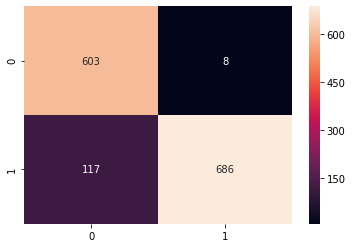

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
Y = [np.argmax(y) for y in y_train]
cm = confusion_matrix(Y, [np.argmax(pred) for pred in preds2])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
plt.savefig('Confusion_matrix_1_1.png')
print('conf matrix', confusion_matrix(Y, [np.argmax(pred) for pred in preds2]))

# Sensitivity analysis

## All elements

Count the average of how many times an atom show up in the structure

Assigning positions of each element in vocabulary

In [46]:
importances_dict = vocabulary_elements.copy()
elem_dict = {}

for element in tqdm(importances_dict.keys()):
    sites = []
    totmol = 0
    for clust in range(len(dict_atoms_pos)): #for each cluster
        nums = dict_atoms_pos[clust].keys() #molecules
        for num in nums: #for each molecule
            elems = dict_atoms_pos[clust][num].keys() #elements of the molecule
            if element in elems:
                idx_el = (totmol, dict_atoms_pos[clust][num][element])
                sites.append(idx_el)
            totmol += 1
    elem_dict[element] = sites

100%|██████████| 11/11 [00:00<00:00, 134.77it/s]


In [47]:
importances_dict = vocabulary_elements.copy()
elem_core = {}
for element in tqdm(importances_dict.keys()):
    core_sites = []
    totmol = 0
    for clust in range(len(dict_core_pos)): #for each cluster
        nums = dict_core_pos[clust].keys() #molecules
        for num in nums: #for each molecule
            elems = dict_core_pos[clust][num].keys() #elements of the molecule
            if element in elems:
                core_idx = (totmol, dict_core_pos[clust][num][element])
                core_sites.append(core_idx)
            totmol += 1
    elem_core[element] = core_sites

100%|██████████| 11/11 [00:00<00:00, 217.15it/s]


In [48]:
len(elem_core['H'][11][1])

21

In [49]:
len(elem_dict['H'][11][1])

1197

Average number of each element per molecule

In [50]:
average_elements = vocabulary_elements.copy()
tot_elements = vocabulary_elements.copy()
tot_molecs = np.sum([len(j.keys()) for j in dict_atoms_pos])
for i in vocabulary_elements.keys():
    total_element = np.sum([len(elem_dict[i][j][1]) for j in range(len(elem_dict[i]))])
    print(i, total_element)
    tot_elements[i] = total_element
    average_elements[i] = total_element/tot_molecs
    
#assert average_elements["C"] == 18.418670438472418

average_elements

Br 28987
S 138895
I 7028
O 404098
H 1532412
C 4561060
N 473581
Cl 80496
F 64038
P 179
Fe 0


{'Br': 20.356039325842698,
 'S': 97.53862359550561,
 'I': 4.935393258426966,
 'O': 283.77668539325845,
 'H': 1076.1320224719102,
 'C': 3202.991573033708,
 'N': 332.5709269662921,
 'Cl': 56.52808988764045,
 'F': 44.97050561797753,
 'P': 0.12570224719101122,
 'Fe': 0.0}

Computing the "mean" importance of each element

In [61]:
compute_importance = False
load_importance = True

In [62]:
import json
if compute_importance: 
    for element in ['I']:
        print(element)
        old_X = X.copy()
        channel = vocabulary_elements[element]
        new_X_train = np.zeros((len(X),x,y,z,l))
        for n in tqdm(range(len(X))):
            new_X_train[n] = X[n].todense()

        #all sites with this element 
        molec = [i for (i,j) in elem_dict[element]]
        pos = [j for (i,j) in elem_dict[element]]
        for at, coo in tqdm(zip(molec, pos), total = len(molec)):
            for idx in coo:
                i = idx[0];  j = idx[1];  k = idx[2]
                if not new_X_train[at, i, j, k, channel] != 0:
                    new_X_train[at, i, j, k, channel] = X[at].todense()[i,j,k,channel]
                new_X_train[at,i,j,k,channel] = 0

        print('Building new sparsed matrix')        
        new_X_sparse = sparse.COO(new_X_train)

        #Calculating importance  

        test_generator = DataGenerator(test_idx, labels=y_train, X=new_X_sparse, **params_test)

        print('Computing performances')
        ac2 = loaded_model.evaluate_generator(generator=test_generator)
        print(ac1, ac2)
        importance = ac2[1]-ac1[1] 
        importances_dict[element] =  importance
        
if load_importance:
        with open(os.path.join(folder_topass, 'importances.json'), 'r') as fp:
            importances_dict = json.load( fp)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/modeorozco/NBD/dani_structural/topass_05_2_rec/importances.json'

In [58]:
importances_dict

{'I': 0.0,
 'C': -0.21994341159558195,
 'Br': 0.0,
 'O': -0.04879773316491276,
 'Cl': -0.004950493489836005,
 'S': -0.019801979228495914,
 'N': -0.030410181852176144,
 'H': -0.10396038857848511,
 'F': -0.004950493279069934,
 'P': 0.0}

In [43]:
average_elements

{'I': 0.019801980198019802,
 'C': 18.4024045261669,
 'Br': 0.10113154172560113,
 'O': 2.1994342291371995,
 'Cl': 0.31824611032531824,
 'S': 0.5487977369165488,
 'N': 2.6074964639321077,
 'H': 18.35926449787836,
 'F': 0.4872701555869873,
 'P': 0.0007072135785007072}

In [44]:
importances_dict_mean = {}
for elem in importances_dict.keys():
    importances_dict_mean[elem] = importances_dict[elem]/average_elements[elem]

In [45]:
importances_dict_mean

{'I': 0.0,
 'C': -0.011951884400912835,
 'Br': 0.0,
 'O': -0.022186493471121106,
 'Cl': -0.015555550654729137,
 'S': -0.03608247246017168,
 'N': -0.011662597542440213,
 'H': -0.005662557374806546,
 'F': -0.01015964803571101,
 'P': 0.0}

## Importance*appearance

<BarContainer object of 10 artists>

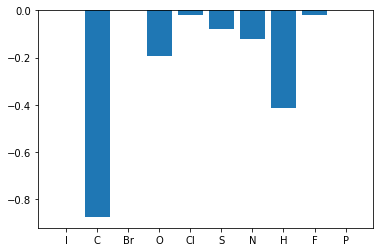

In [51]:
importance_values = [importances_dict_mean[element]*tot_elements[element] for element in importances_dict.keys()]
norm = np.linalg.norm(importance_values)
plt.bar(importances_dict_mean.keys(), (importance_values/norm))
                    

## Importance

dict_keys(['I', 'C', 'Br', 'O', 'Cl', 'S', 'N', 'H', 'F', 'P']) dict_values([0.0, -0.21994341159558195, 0.0, -0.04879773316491276, -0.004950493489836005, -0.019801979228495914, -0.030410181852176144, -0.10396038857848511, -0.004950493279069934, 0.0])


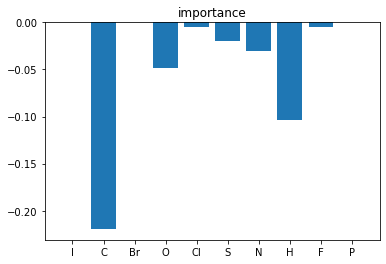

In [47]:
print(importances_dict.keys(), importances_dict.values())
%matplotlib inline 
plt.bar(importances_dict.keys(), (importances_dict.values()))
plt.title('importance')
plt.savefig('importance_1_1.png')
plt.show()

# Mean importance

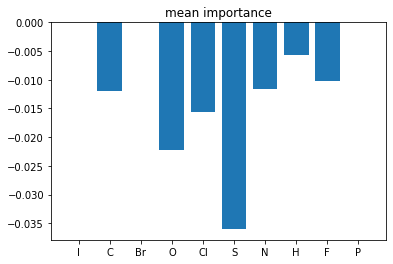

In [48]:
plt.bar(importances_dict.keys(), (importances_dict_mean.values()))
plt.title('mean importance')
plt.savefig('mean_importance_1_1.png')

## Appereance

['I', 'C', 'Br', 'O', 'Cl', 'S', 'N', 'H', 'F', 'P']
[0.019801980198019802, 18.4024045261669, 0.10113154172560113, 2.1994342291371995, 0.31824611032531824, 0.5487977369165488, 2.6074964639321077, 18.35926449787836, 0.4872701555869873, 0.0007072135785007072]


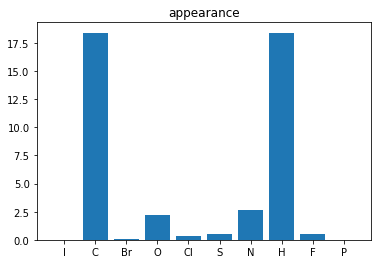

In [49]:
print(list(importances_dict.keys()))
print(list(average_elements.values()))
%matplotlib inline  
plt.bar(list(importances_dict.keys()), list(average_elements.values()))
plt.title('appearance')
plt.savefig('appearance_1_1.png')
plt.show()

## One element

In [50]:
elem_dict.keys()

dict_keys(['Br', 'I', 'F', 'Cl', 'O', 'N', 'H', 'C', 'S', 'P'])

In [51]:
params_test = {'dim': (x,y,z),
          'batch_size': 1,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': False}

In [ ]:
nsample=0
sample = X.copy()[nsample]
xs, ys, ls, _ = sample.shape
key = "N"; 
channel = vocabulary_elements[key]
idxs_dict = vocabulary_elements.copy();
print(sample.shape)
pred_generator = DataGenerator(test_idx, labels=y_train, X=[sample], **params_test)

#First prediction
pred = loaded_model.predict_generator(pred_generator)

label_pred = np.argmax(pred)
prob = pred[label_pred]

# CHeck atoms with that channel
idxs = []
for r in range(xs):
    for k in range(ys):
        for m in range(ls):
            if sample[r, k, m, channel] != 0:
                idxs.append([r,k,m])
                idxs_dict[key] = idxs
                print(idxs_dict)

# Remove one atom at a time
importances_per_atom = []
for idxs in idxs_dict[key]:
    x,y,z = idxs
    position = rear_bck_pixel + np.array([+x+1,-y,-z])
    print(position)
    new_sample = X_train.copy()[nsample]
    new_sample[x,y,z,channel] = 0
    pred = model.predict(np.array(new_sample).reshape(1, 20, 20, 20, 9))[0]
    importance = prob - pred[label_pred]
    importances_per_atom.append(importance)
importances_per_atom

## On pixels

In [41]:
side = 20
cm = center_grid
print("CM", cm)
print("Build grid")
grid2 = Grid(cm, side, resolution)
grid2.calculate_pixels()

CM [44.83382734 46.34493052 38.90026504]
Build grid
Calculating pixels...


In [67]:
for k, i in enumerate(range(len(Y))):
    if float(Y[i]) == round(preds2[i,1]):
        print(k, float(Y[i]),preds2[i])

0 1.0 [0.0091068  0.99089324]
1 1.0 [0.00371384 0.99628615]
2 1.0 [0.16118018 0.83881986]
3 1.0 [0.00243777 0.9975623 ]
4 1.0 [0.17786182 0.8221382 ]
5 1.0 [0.26089534 0.7391046 ]
6 1.0 [2.2564817e-04 9.9977440e-01]
7 0.0 [0.95148516 0.04851484]
8 0.0 [9.9985647e-01 1.4352964e-04]
9 1.0 [0.12514421 0.87485576]
10 1.0 [4.9928476e-05 9.9995005e-01]
11 1.0 [0.01087113 0.9891289 ]
12 0.0 [0.98954004 0.01046   ]
13 1.0 [0.00108337 0.9989166 ]
14 1.0 [2.947013e-06 9.999970e-01]
15 0.0 [0.99842995 0.00157005]
16 0.0 [9.999143e-01 8.570698e-05]
17 1.0 [0.0080614  0.99193853]
18 0.0 [0.9967552  0.00324476]
19 1.0 [0.3519766 0.6480234]
20 0.0 [0.9687576  0.03124236]
21 1.0 [0.02056639 0.9794336 ]
22 1.0 [0.1845382  0.81546175]
23 0.0 [9.990231e-01 9.768737e-04]
24 0.0 [9.9998605e-01 1.3937494e-05]
25 1.0 [0.0054832 0.9945168]
26 0.0 [0.9886945  0.01130552]
27 1.0 [0.00578001 0.99422   ]
28 1.0 [0.01670954 0.98329043]
29 0.0 [9.9954492e-01 4.5506272e-04]
30 0.0 [0.98799664 0.01200337]
31 1.0 [0.4

714 1.0 [0.40513358 0.5948664 ]
715 0.0 [0.99885833 0.00114162]
716 0.0 [0.99610007 0.00389987]
717 1.0 [0.05989272 0.9401072 ]
718 0.0 [9.9998248e-01 1.7529386e-05]
719 1.0 [0.08745524 0.9125448 ]
720 1.0 [0.00764832 0.9923517 ]
721 1.0 [0.00764832 0.9923517 ]
722 1.0 [0.00764832 0.9923517 ]
723 1.0 [0.00764832 0.9923517 ]
724 1.0 [0.00764832 0.9923517 ]
725 1.0 [0.00764832 0.9923517 ]
726 1.0 [0.00764832 0.9923517 ]
727 1.0 [0.00764832 0.9923517 ]
728 1.0 [0.00764832 0.9923517 ]
729 1.0 [0.00764832 0.9923517 ]
730 0.0 [9.9977237e-01 2.2767985e-04]
731 1.0 [3.0858225e-06 9.9999690e-01]
732 0.0 [9.9997807e-01 2.1971733e-05]
733 0.0 [9.999801e-01 1.986011e-05]
734 0.0 [0.97542965 0.02457041]
735 0.0 [9.9915123e-01 8.4871735e-04]
736 1.0 [0.01589189 0.9841081 ]
737 1.0 [0.01470657 0.98529345]
738 0.0 [0.9950111  0.00498896]
739 1.0 [1.3102742e-06 9.9999869e-01]
741 1.0 [0.09053847 0.90946156]
742 0.0 [0.8934753  0.10652474]
743 0.0 [9.9951124e-01 4.8872142e-04]
746 0.0 [9.999931e-01 6.93

In [68]:
if include_rec:
    sdfs_rec = [s for i,s in enumerate(sdfs) if i%2 != 0]
    sdfs_lig = [s for i,s in enumerate(sdfs) if i%2 == 0]

In [66]:
customizing_pdbs(clusters=[0], nsample=[4])

	-----> cluster 0 how many in cluster


  0%|          | 0/60 [00:00<?, ?it/s]

	----->> molecule 0 of:  152
	----->> molecule 1 of:  152
	----->> molecule 2 of:  152
	----->> molecule 3 of:  152
	----->> molecule 4 of:  152
Analysis on pixels...
Len x 1414
Dimensions 40 40 40 11
Preparing generator
pred baseline [0.1778618 0.8221382]
true label [0. 1.]


  0%|          | 0/274 [00:00<?, ?it/s]

Analysis on pixels...
Len x 1414
Dimensions 40 40 40 11
Preparing generator
pred baseline [0.1778618 0.8221382]
true label [0. 1.]


100%|██████████| 274/274 [00:31<00:00,  8.80it/s]


pdb written on clust_0_4_lig_mod.pdb
pdb written on clust_0_4_rec_mod.pdb
	----->> molecule 5 of:  152
	----->> molecule 6 of:  152
	----->> molecule 7 of:  152
	----->> molecule 8 of:  152
	----->> molecule 9 of:  152
	----->> molecule 10 of:  152
	----->> molecule 11 of:  152
	----->> molecule 12 of:  152
	----->> molecule 13 of:  152
	----->> molecule 14 of:  152
	----->> molecule 15 of:  152
	----->> molecule 16 of:  152
	----->> molecule 17 of:  152
	----->> molecule 18 of:  152
	----->> molecule 19 of:  152
	----->> molecule 20 of:  152
	----->> molecule 21 of:  152
	----->> molecule 22 of:  152
	----->> molecule 23 of:  152
	----->> molecule 24 of:  152
	----->> molecule 25 of:  152
	----->> molecule 26 of:  152
	----->> molecule 27 of:  152
	----->> molecule 28 of:  152
	----->> molecule 29 of:  152
	----->> molecule 30 of:  152
	----->> molecule 31 of:  152
	----->> molecule 32 of:  152
	----->> molecule 33 of:  152
	----->> molecule 34 of:  152
	----->> molecule 35 of:  152
	

In [227]:
X0 = X[nsample].todense()
labels, positions, labels_core, pos_core, size = labels_to_plot(X0, folder, elem_core, nsample, vocabulary_elements)
#print("molecule name", total_names[nsample])
print("Index inside file", total_indices[nsample])

100%|██████████| 40/40 [00:00<00:00, 231.34it/s]


Index inside file 68


In [213]:
#%matplotlib notebook
#plot_3d(labels_core, labels, pos_core, positions, size, vocabulary_elements, centers=True)

In [125]:
params_test = {'dim': (x,y,z),
          'batch_size': 10,
          'n_classes': 2,
          'n_channels': l,
          'shuffle': False,
          'tofit': False}

In [262]:
test_generator = DataGenerator([nsample], labels=y_train, X=X, **params_test)

In [263]:
pred_baseline = loaded_model.predict_generator(test_generator)[0]
true_label = y_train[nsample]
label = np.argmax(pred_baseline)
true_label[label], pred_baseline[label]

1 1


(1.0, 0.52147907)

In [264]:
X0.shape

(20, 20, 20, 10)

In [265]:
pos_ligand = np.load(os.path.join(folder_topass, "pixels_imp_{}_{}.npy".format(nsample, resolution)))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/modeorozco/NBD/dani_structural/topass_1_1/pixels_imp_0_1.0.npy'

In [266]:
pos_ligand.shape, positions.shape

NameError: name 'pos_ligand' is not defined

In [77]:
pos_ligand = poses

In [78]:
#fig = px.scatter_3d(x=pos_ligand[:,0], y=pos_ligand[:,1], z=pos_ligand[:,2], color=pos_ligand)
#fig.show()

<IPython.core.display.Javascript object>


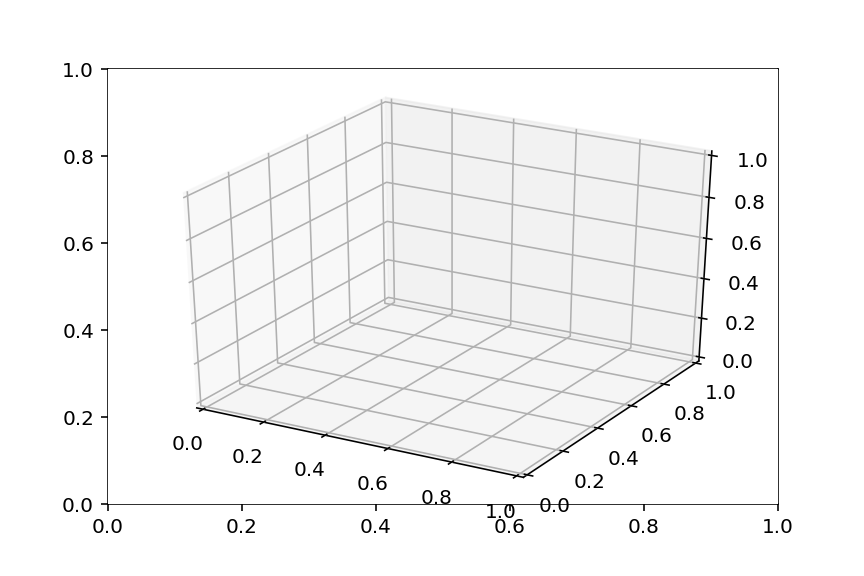

/opt/anaconda2/envs/modtox/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Requested projection is different from current axis projection, creating new axis with requested projection.



NameError: name 'pos_ligand' is not defined

In [77]:
%matplotlib notebook
fig, ax = plt.subplots()
ax = fig.gca(projection='3d')
rescaled = rescale_vector(pos_ligand[:,3])
surf = ax.scatter(pos_ligand[:,0], pos_ligand[:,1], pos_ligand[:,2], c=rescaled, s = 300, cmap='rainbow', alpha=1, marker='o')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.savefig('Heatmap_1_1.png')
plt.show()

In [15]:
####

In [ ]:
x, y, z = np.unravel_index(np.argsort(importance_pixel, axis=None), importance_pixel.shape)

In [ ]:

nsamples = len(X)
x,y,z,l = X[0].shape
blank_pixel = np.zeros(l)

importance_pixel = np.zeros((x,y,z))

for coordx in tqdm(range(x)):
    for coordy in range(y):
        for coordz in range(z):
            new_X_train = X[nsample].todense()
            if 1 in new_X_train[coordx,coordy,coordz]:
                new_X_train[coordx, coordy, coordz] = blank_pixel
                new_X_sparse = [sparse.COO(new_X_train)]
                test_generator = DataGenerator([0], labels=y_train, X=new_X_sparse, **params_test)
                pred =  loaded_model.predict_generator(test_generator)[0]
                if true_label[label] == 1:
                    importance_single_pixel = pred[1] - pred_baseline[1] 
                else:
                    importance_single_pixel = pred_baseline[1] - pred[1] 
            else:
                importance_single_pixel=0
            importance_pixel[coordx,coordy,coordz] = importance_single_pixel


In [ ]:
idx_imp = 2
idx = [x[-idx_imp], y[-idx_imp], z[-idx_imp]]
importance = importance_pixel[x[-idx_imp], y[-idx_imp], z[-idx_imp]]
print(importance, idx, rear_bck_pixel + np.array([+x[-idx_imp]+1,-y[-idx_imp],-z[-idx_imp]]))

In [ ]:
def visualize(result, y_train, nsample):
    npixel = 20
    heat_map_grids = []
    heat_elements_grids = []
    for plane in range(20):
        sample = X_train[nsample][:,:,plane].copy()
        explanation_grid = np.zeros((npixel, npixel)).copy()
        explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += 1
                        explanation_str_grid[i, j] += element
        heat_map_grids.append(explanation_grid)
        heat_elements_grids.append(explanation_str_grid)
    
    final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
    final_grid = np.zeros((npixel, npixel)).copy()
    for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
        final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
        final_grid += grid
    
    print(final_grid_elements)
    
    print("Class", np.argmax(y_train[nsample]), "Prob", y_train[nsample])
    data = final_grid
    plt.matshow(data)
    plt.show()

In [ ]:
vocabulary_elements

In [ ]:
X_train[nsample][x[-idx_imp], y[-idx_imp], z[-idx_imp]]

# Visualize Filters

As many dimensions as filter X channel --> Too many

In [ ]:
model.summary()

In [ ]:
convolutionals_layers = []
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    else:
        convolutionals_layers.append(layer)
convolutionals_layers

In [ ]:
for layer in convolutionals_layers:
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# cannot easily visualize filters lower down
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
# retrieve weights from the second hidden layer
filters, biases = convolutionals_layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 2, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(15):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 15, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        final_filter = np.zeros((f.shape[0], f.shape[1], f.shape[3]))
        for i in range(f.shape[2]):
            final_filter += f[:,:,i, :]
        pyplot.imshow(final_filter[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

# Feature Map

In [ ]:
# redefine model to output right after the first hidden layer
ixs = [2, 5, 8]
outputs = [model.layers[i].output for i in ixs]
model1 = Model(inputs=model.inputs, outputs=outputs)
samples = X_train[0]
feature_maps = model1.predict(samples.reshape(1, 20, 20, 20, 9))
# plot the output from each block




for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    fig = plt.figure(figsize=(x, y))
    ix = 1
    for _ in range(15):
        # specify subplot and turn of axis
        ax = pyplot.subplot(8, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in gray scale
        final_map = np.zeros((fmap.shape[1], fmap.shape[2], fmap.shape[4]))
        for i in range(fmap.shape[3]):
            final_map += fmap[0, :,:, i, :]
        pyplot.imshow(final_map[:, :, ix-1], cmap='gray')
        ix += 1
# show the figure
    fig.show()

# CMAP

https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

In [ ]:
from keras import backend as K

nsample=0

print(nsample)
#Prediction
argmax = np.argmax(preds[nsample])
#Probability
probability = preds[nsample][argmax]
#Output
output = model.output[:, argmax]
#Las convulutional layer
last_conv_layer = model.get_layer('conv3d_2')
#Intensity of the channels
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_train])

In [ ]:
#For each channel we multiply for its intensity
for i in range(conv_layer_output_value.shape[2]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [ ]:
visualize(X_train, y_train, 0)

In [ ]:
print("Class", argmax, "Prob", probability)
data = final_grid
plt.matshow(data)
plt.show()

In [ ]:
output = np.zeros(conv_layer_output_value[:,:,1].shape)
for i in range(conv_layer_output_value.shape[2]):
    output += conv_layer_output_value[:,:,i]
output

In [ ]:
import cv2
print("Predicted Class", argmax, "Real Class", Y[0], "Prob", probability)
heatmap = abs(np.mean(output, axis=-1))
#heatmap = np.maximum(heatmap, 0)
#heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (20, 20), interpolation = cv2.INTER_CUBIC)
plt.matshow(heatmap)
plt.colorbar()
plt.show()



In [ ]:
#heatmap = np.uint8(255 * heatmap)
#heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#data = cv2.applyColorMap(data, cv2.COLORMAP_BONE)
heatmap_norm = np.maximum(heatmap, 0)
heatmap_norm /= np.max(heatmap_norm)
superimposed_img =  7*heatmap_norm +  data
plt.imshow(superimposed_img)


In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

In [ ]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [ ]:
cam_model.summary()

In [ ]:
features,results = cam_model.predict(X_train)
features.shape, results.shape

In [ ]:
results

In [ ]:
for i, result in enumerate(results):
    if np.argmax(result) == 1:
        print(i)

In [ ]:
for idx in range(2):
    features_for_one_img = features[idx,:,:,:]
    #height_roomout = X_train.shape[1]/features_for_one_img.shape[0]
    #width_roomout  = X_train.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    #cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    pred = np.argmax(results[idx])
    cam_features = features_for_one_img
    
    
    plt.figure(facecolor='white')
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' +str( pred )+ ', Probability = ' + str(results[idx][pred])

    

    #plt.imshow(np.squeeze(X_train[idx],-1), alpha=0.5)

    for i in range(6):
        plt.figure(facecolor='white')
        new_buf  = buf + "plane {}".format(i)
        plt.xlabel(new_buf)
        plt.imshow(cam_output[:,:,i], cmap='jet', alpha=0.5)


In [ ]:
print(explanation_grid)

In [ ]:
sample

In [ ]:
vocabulary_elements